In [13]:
import matplotlib.pyplot as plt
import gc

# Astropy imports
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb

# Image visualization routines.
import lsst.afw.display as afwDisplay
# The Butler projvides programmatic access to LSST data products.
from lsst.daf.butler import Butler
# Geometry package
import lsst.geom as geom
# Object for multi-band exposures
from lsst.afw.image import MultibandExposure

plt.style.use('tableau-colorblind10')
%matplotlib inline

In [14]:
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector

In [15]:
def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox': bbox}

    cutout_image = butler.get(datasetType, parameters=parameters,
                              dataId=coaddId)

    return cutout_image

In [16]:
def createRGB(image, bgr="gri", stretch=1, Q=10, scale=None):
    """
    Create an RGB color composite image.

    Parameters
    ----------
    image : `MultibandExposure`
        `MultibandExposure` to display.
    bgr : sequence
        A 3-element sequence of filter names (i.e., keys of the exps dict)
        indicating what band to use for each channel. If `image` only has
        three filters then this parameter is ignored and the filters
        in the image are used.
    stretch: int
        The linear stretch of the image.
    Q: int
        The Asinh softening parameter.
    scale: list of 3 floats, each less than 1. (default: None)
        Re-scales the RGB channels.

    Returns
    -------
    rgb: ndarray
        RGB (integer, 8-bits per channel) colour image as an NxNx3 numpy array.
    """

    # If the image only has 3 bands, reverse the order of the bands
    #   to produce the RGB image
    if len(image) == 3:
        bgr = image.filters

    # Extract the primary image component of each Exposure with the
    #   .image property, and use .array to get a NumPy array view.

    if scale is None:
        r_im = image[bgr[2]].array  # numpy array for the r channel
        g_im = image[bgr[1]].array  # numpy array for the g channel
        b_im = image[bgr[0]].array  # numpy array for the b channel
    else:
        # manually re-scaling the images here
        r_im = image[bgr[2]].array * scale[0]
        g_im = image[bgr[1]].array * scale[1]
        b_im = image[bgr[0]].array * scale[2]

    rgb = make_lupton_rgb(image_r=r_im,
                          image_g=g_im,
                          image_b=b_im,
                          stretch=stretch, Q=Q)
    # "stretch" and "Q" are parameters to stretch and scale the pixel values

    return rgb

In [17]:
# USE TAP SERVICE
# Import the Rubin TAP service utilities
from lsst.rsp import get_tap_service, retrieve_query
# Import general python packages
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas
from pandas.testing import assert_frame_equal
from astropy import units as u
from astropy.coordinates import SkyCoord

service = get_tap_service()
assert service is not None
assert service.baseurl == "https://data.lsst.cloud/api/tap"

# A cone search on the Object table will be a common TAP query. In this example, a circle centered on (RA, Dec) = (62.0, -37.0)
# with a radius of 1 degree is used.

center_coords = SkyCoord(62, -37, frame='icrs', unit='deg')
search_radius = 1.0*u.deg

print(center_coords)
print(search_radius)

use_center_coords = "62, -37"
use_radius = "1.0"

<SkyCoord (ICRS): (ra, dec) in deg
    (62., -37.)>
1.0 deg


In [18]:
bright_galaxy_query = ("clean",
                       "extendedness == 1",
                       "mag_g_cModel- mag_i_cModel < 5",
                       "mag_g_cModel- mag_i_cModel > 1.8",
                       "mag_g_cModel- mag_r_cModel < 3",
                       "mag_g_cModel- mag_r_cModel > 0.6",
                       
                       "mag_r_cModel < 22.5",
                       "mag_r_cModel > 18",
                       "mag_g_cModel > 20",
                       "mag_i_cModel > 18.2",
                       
                       "snr_g_cModel > 10",
                       "snr_r_cModel > 10",
                       "snr_i_cModel > 10",)

In [19]:
%%time
query = "SELECT objectId, detect_isPrimary, " + \
        "coord_ra AS ra, coord_dec AS dec, tract, patch,  " + \
        "scisql_nanojanskyToAbMag(g_cModelFlux) AS mag_g_cModel, " + \
        "scisql_nanojanskyToAbMag(r_cModelFlux) AS mag_r_cModel, " + \
        "scisql_nanojanskyToAbMag(i_cModelFlux) AS mag_i_cModel, " + \
        "r_extendedness " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " + \
        "CIRCLE('ICRS', " + use_center_coords + ", " + use_radius + ")) = 1 " + \
        "AND detect_isPrimary = 1 " + \
        "AND scisql_nanojanskyToAbMag(g_cModelFlux) - scisql_nanojanskyToAbMag(i_cModelFlux) < 5.0 " + \
        "AND scisql_nanojanskyToAbMag(g_cModelFlux) - scisql_nanojanskyToAbMag(i_cModelFlux) > 1.8 " + \
        "AND scisql_nanojanskyToAbMag(g_cModelFlux) - scisql_nanojanskyToAbMag(r_cModelFlux) < 3.0 " + \
        "AND scisql_nanojanskyToAbMag(g_cModelFlux) - scisql_nanojanskyToAbMag(r_cModelFlux) > 0.6 " + \
        "AND scisql_nanojanskyToAbMag(r_cModelFlux) < 22.5 " + \
        "AND scisql_nanojanskyToAbMag(r_cModelFlux) > 18.0 " + \
        "AND scisql_nanojanskyToAbMag(g_cModelFlux) > 20.0 " + \
        "AND scisql_nanojanskyToAbMag(i_cModelFlux) > 18.2 " + \
        "AND r_extendedness IS NOT NULL " + \
        "AND r_extendedness > 0 "
results = service.search(query).to_table().to_pandas()

CPU times: user 466 ms, sys: 6.56 ms, total: 472 ms
Wall time: 2.05 s


In [20]:
results

,objectId,detect_isPrimary,ra,dec,tract,patch,mag_g_cModel,mag_r_cModel,mag_i_cModel,r_extendedness
0,1567929969487670941,True,61.003225,-37.599231,3637,40,22.341257,20.771771,20.172821,1.0
1,1567929969487671128,True,61.081724,-37.597762,3637,40,23.915242,22.369007,21.281788,1.0
2,1567929969487671025,True,61.072816,-37.598984,3637,40,23.931586,22.457893,21.816990,1.0
3,1567929969487671775,True,61.062111,-37.593885,3637,40,23.701203,22.251161,21.488782,1.0
4,1567929969487671516,True,61.125806,-37.593927,3637,40,23.776272,22.476762,20.733906,1.0
...,...,...,...,...,...,...,...,...,...,...
18012,1651440076640515966,True,62.839272,-36.309152,3831,28,22.409182,21.167448,20.343256,1.0
18013,1651440076640516653,True,62.863452,-36.302347,3831,28,23.076226,22.026024,21.243555,1.0
18014,1651440076640516145,True,62.843511,-36.305109,3831,28,20.981782,19.797323,18.576636,0.0
18015,1651440076640516097,True,62.874341,-36.308176,3831,28,22.303330,20.944850,19.197681,0.0


In [21]:
len(results)

18017

#### Create an instance for Butler

In [22]:
# Import packages for Section 3.0 Image Access
import lsst.daf.butler as dafButler
import lsst.geom
import lsst.afw.display as afwDisplay

config = 'dp02'
collection = '2.2i/runs/DP0.2'

butler = dafButler.Butler(config, collections=collection)

ra =  61.0032254
dec =  -37.5992313


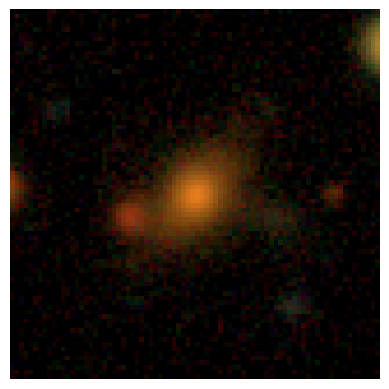

In [11]:
index = 0

ra = results.ra[index]    
dec = results.dec[index]  

print('ra = ', ra)
print('dec = ', dec)

cut = 80 # in pixels

cutout_image_g = cutout_coadd(butler, ra, dec, band='g',
                              datasetType='deepCoadd', cutoutSideLength=cut)
cutout_image_r = cutout_coadd(butler, ra, dec, band='r',
                              datasetType='deepCoadd', cutoutSideLength=cut)
cutout_image_i = cutout_coadd(butler, ra, dec, band='i',
                              datasetType='deepCoadd', cutoutSideLength=cut)

# Multiband exposures need a list of images and filters
coadds = [cutout_image_g, cutout_image_r, cutout_image_i]
coadds = MultibandExposure.fromExposures(['g', 'r', 'i'], coadds)

rgb_original = createRGB(coadds.image, bgr=['g', 'r', 'i'], scale=None)
fig, ax = plt.subplots()
ax.imshow(rgb_original)
ax.set_axis_off()
plt.imshow(rgb_original)

#plt.savefig('/home/luiseduardocantero/notebooks/imagenes_galaxias/hola5.png', bbox_inches='tight',pad_inches = 0, dpi=36) #36 para que den 217x217

## Saving all images

In [12]:

fig = plt.figure(figsize=(20,100)) 


for i in range(0, 7):  #len(results) ):

    index = i
    ra = results.ra[index]    
    dec = results.dec[index]  

    cut = 60 # in pixels

    try:
        cutout_image_g = cutout_coadd(butler, ra, dec, band='g',
                                      datasetType='deepCoadd', cutoutSideLength = cut)
        cutout_image_r = cutout_coadd(butler, ra, dec, band='r',
                                      datasetType='deepCoadd', cutoutSideLength = cut)
        cutout_image_i = cutout_coadd(butler, ra, dec, band='i',
                                      datasetType='deepCoadd', cutoutSideLength = cut)
    except:
        print("No se pudo hacer el corte, se realizará uno mas pequeño")
        cutout_image_g = cutout_coadd(butler, ra, dec, band='g',
                                      datasetType='deepCoadd', cutoutSideLength = cut//2)
        cutout_image_r = cutout_coadd(butler, ra, dec, band='r',
                                      datasetType='deepCoadd', cutoutSideLength = cut//2)
        cutout_image_i = cutout_coadd(butler, ra, dec, band='i',
                                      datasetType='deepCoadd', cutoutSideLength = cut//2)        
        
    # Multiband exposures need a list of images and filters
    coadds = [cutout_image_g, cutout_image_r, cutout_image_i]
    coadds = MultibandExposure.fromExposures(['g', 'r', 'i'], coadds)

    rgb_original = createRGB(coadds.image, bgr=['g', 'r', 'i'], scale=None)
    fig, ax = plt.subplots()
    ax.imshow(rgb_original)
    ax.set_axis_off()
    plt.imshow(rgb_original)
    
    ruta = f'/home/luiseduardocantero/notebooks/pruebas/' + str(results.objectId[index]) +  '.png'

    plt.savefig(ruta, bbox_inches='tight',pad_inches = 0, dpi=36) # dpi=36 para que den 217x217 pxls
    remove_figure(fig)
plt.show()    

<Figure size 2000x10000 with 0 Axes>